In [1]:
import os
import wget
import tarfile
import numpy as np
import string
from tools import *

In [42]:
proteins = ('Hst5', 'Sic1', 'Tau', 'TIA1')
sizes = (10000, 15000, 30000, 10001)

In [3]:
exps = {
    'Hst5': np.loadtxt('../SAXS_data/saxs_hst5_323k.dat'),
    'Sic1': np.loadtxt('../SAXS_data/saxs_sic1.dat'),
    'aSyn': np.loadtxt('../SAXS_data/saxs_aSyn.dat'),
    'Tau': np.loadtxt('../SAXS_data/saxs_tau.dat'),
    'TIA1': np.loadtxt('../SAXS_data/saxs_tia1.dat')
}
# To make q units coherent
exps['Sic1'][...,0] = exps['Sic1'][...,0]*10
exps['TIA1'][...,0] = exps['TIA1'][...,0]*10

# Load Grids
grids = {}
for p in proteins:
    grids[p] = np.loadtxt('GRID_'+p)
    #calculate \gamma
    g = np.log(grids[p][...,4]/grids[p][...,5])
    g = g.reshape(len(g),1)
    grids[p] = np.append(grids[p], g, axis=1)

/storage1/francesco/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide


/storage1/francesco/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later


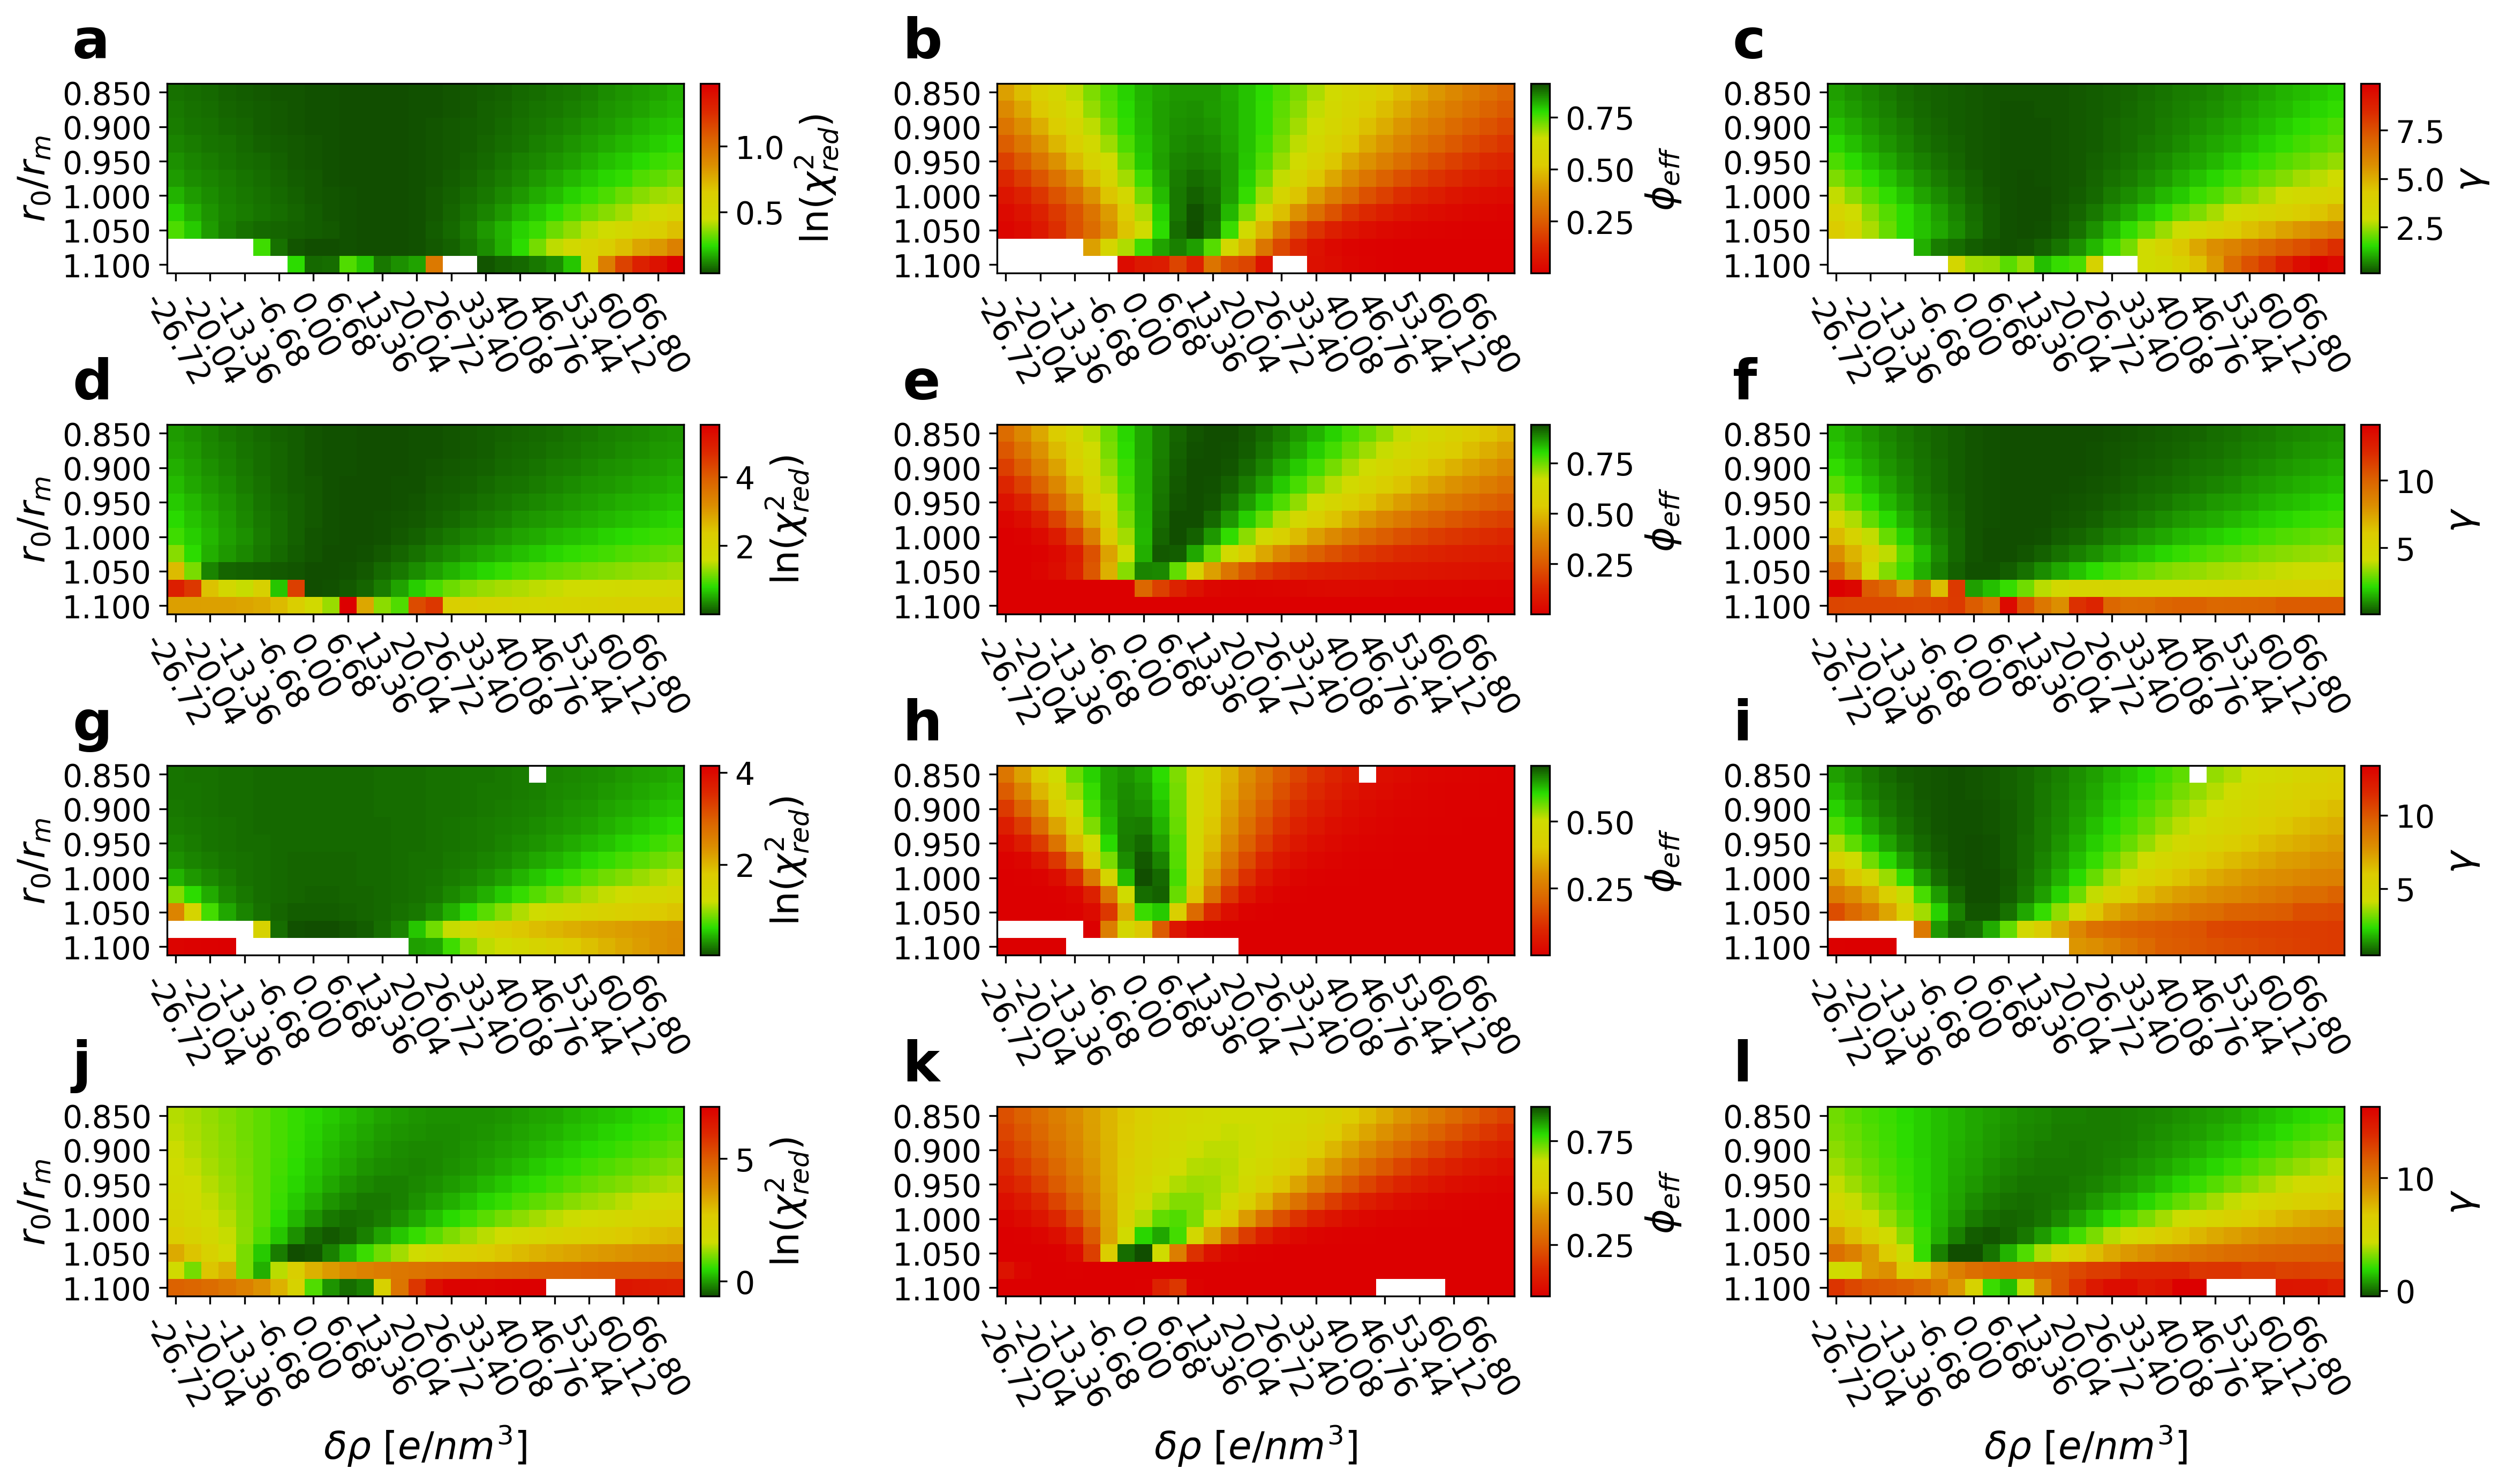

In [4]:
# Plotting grids
mpl.rcParams['font.size'] = 14
fig, axs = plt.subplots(nrows=4,ncols=3, figsize=(20,10), facecolor='w', dpi=300, gridspec_kw={'hspace':0.8,'wspace':0.001})
for i,p in enumerate(grids.keys()):
    im = axs[i,0].imshow(np.log(grids[p][...,4]).reshape(len(dro),len(r0)).T, cmap=rtg)
    plt.colorbar(im, ax=axs[i,0],shrink=1, pad=0.02, aspect=10).set_label(r'$\ln(\chi^2_{red})$', fontsize=17)
    
    im = axs[i,1].imshow(grids[p][...,5].reshape(len(dro),len(r0)).T, cmap=rtg_r)
    plt.colorbar(im, ax=axs[i,1],shrink=1, pad=0.02, aspect=10).set_label(r'$\phi_{eff}$', fontsize=17)
    
    im = axs[i,2].imshow(grids[p][...,6].reshape(len(dro),len(r0)).T, cmap=rtg)
    plt.colorbar(im, ax=axs[i,2],shrink=1, pad=0.02, aspect=10).set_label(r'$\gamma$', fontsize=17)

c=0
for i in range(4):
    axs[i,0].set_ylabel(r'$r_0/r_m$', fontsize=17)
    for j in range(3):
        axs[i,j].text(-6,-2, string.ascii_lowercase[c], fontsize=25, weight='bold')
        axs[i,j].set_yticks(np.arange(0,len(r0),2))
        axs[i,j].set_yticklabels(yt)
        axs[i,j].set_xticks(np.arange(0,len(dro),2))
        axs[i,j].set_xticklabels(xt, Rotation=300)
        axs[3,j].set_xlabel(r'$\delta\rho$ $[e/nm^3]$', fontsize=17)
        c+=1

plt.savefig('figure1.pdf', dpi=300, facecolor='w', edgecolor='w', orientation='portrait')
plt.show()

In [5]:
# Finding \gamma minima
mins = {}
for k,v in grids.items():
    mins[k] = minfind(v)
    print(mins[k][0])
    print('Best ensemble '+k)
    print('dro: '+str(mins[k][1]))
    print('r0: '+str(mins[k][2]))
    print('chi2: '+str(v[...,4][mins[k][0]]))
    print('phi_eff: '+str(v[...,5][mins[k][0]]))
    print('\n')

129
Best ensemble Hst5
dro: 10.02
r0: 1.05
chi2: 1.0361
phi_eff: 0.911


125
Best ensemble Sic1
dro: 10.02
r0: 0.95
chi2: 1.0236
phi_eff: 0.9405


94
Best ensemble Tau
dro: 0.0
r0: 1.0
chi2: 1.1363
phi_eff: 0.7072


85
Best ensemble TIA1
dro: -3.34
r0: 1.05
chi2: 0.5398
phi_eff: 0.8841




In [6]:
# Finding the global minimum

# Normalize \gamma
s = 0
for k,v in grids.items():
    #min to 0
    shift = np.nanmin(v[...,6])
    tmp = v[...,6] - shift
    
    #rescale 0-1
    scale = np.nanmax(v[...,6])
    tmp /= scale
    
    s += tmp
s = s/len(proteins)
gmin = np.nanargmin(s)
print( gmin )
print( 'Global minimum dro: %.3f'%(grids['Hst5'][gmin][1]*3.34) )
print( 'Global minimum r0: %.3f'%(grids['Hst5'][gmin][2]) )

106
Global minimum dro: 3.340
Global minimum r0: 1.025


In [3]:
# Download ensembles from Zenodo
url = 'https://zenodo.org/record/5500084/files/ENSEMBLES.tar?download=1'
filename = wget.download(url)

# Release tarbomb
my_tar = tarfile.open('ENSEMBLES.tar')
my_tar.extractall('.')
my_tar.close()

for p in proteins:
    if p == 'TIA1':
        my_tar = tarfile.open('TIA1.tar')
        my_tar.extractall('.')
        my_tar.close()
        os.rename('Backmapping', 'TIA1_ENSEMBLE')
    else:
        my_tar = tarfile.open(p+'.tar')
        my_tar.extractall('.')
        my_tar.close()
        os.rename('pulchraed', p+'_ENSEMBLE')

In [ ]:
# Download set of weights obtained from grid scanning+optimization
url = 'https://zenodo.org/record/5500084/files/Pepsi_WEIGHTS.tar?download=1'
filename = wget.download(url)
my_tar = tarfile.open('Pepsi_WEIGHTS.tar')
my_tar.extractall('.')
my_tar.close()

In [8]:
ent = {}
for k,v in grids.items():
    ent[k] = grid_entropy(v, k+'_WEIGHTS/', mins[k][0])

/storage1/francesco/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  


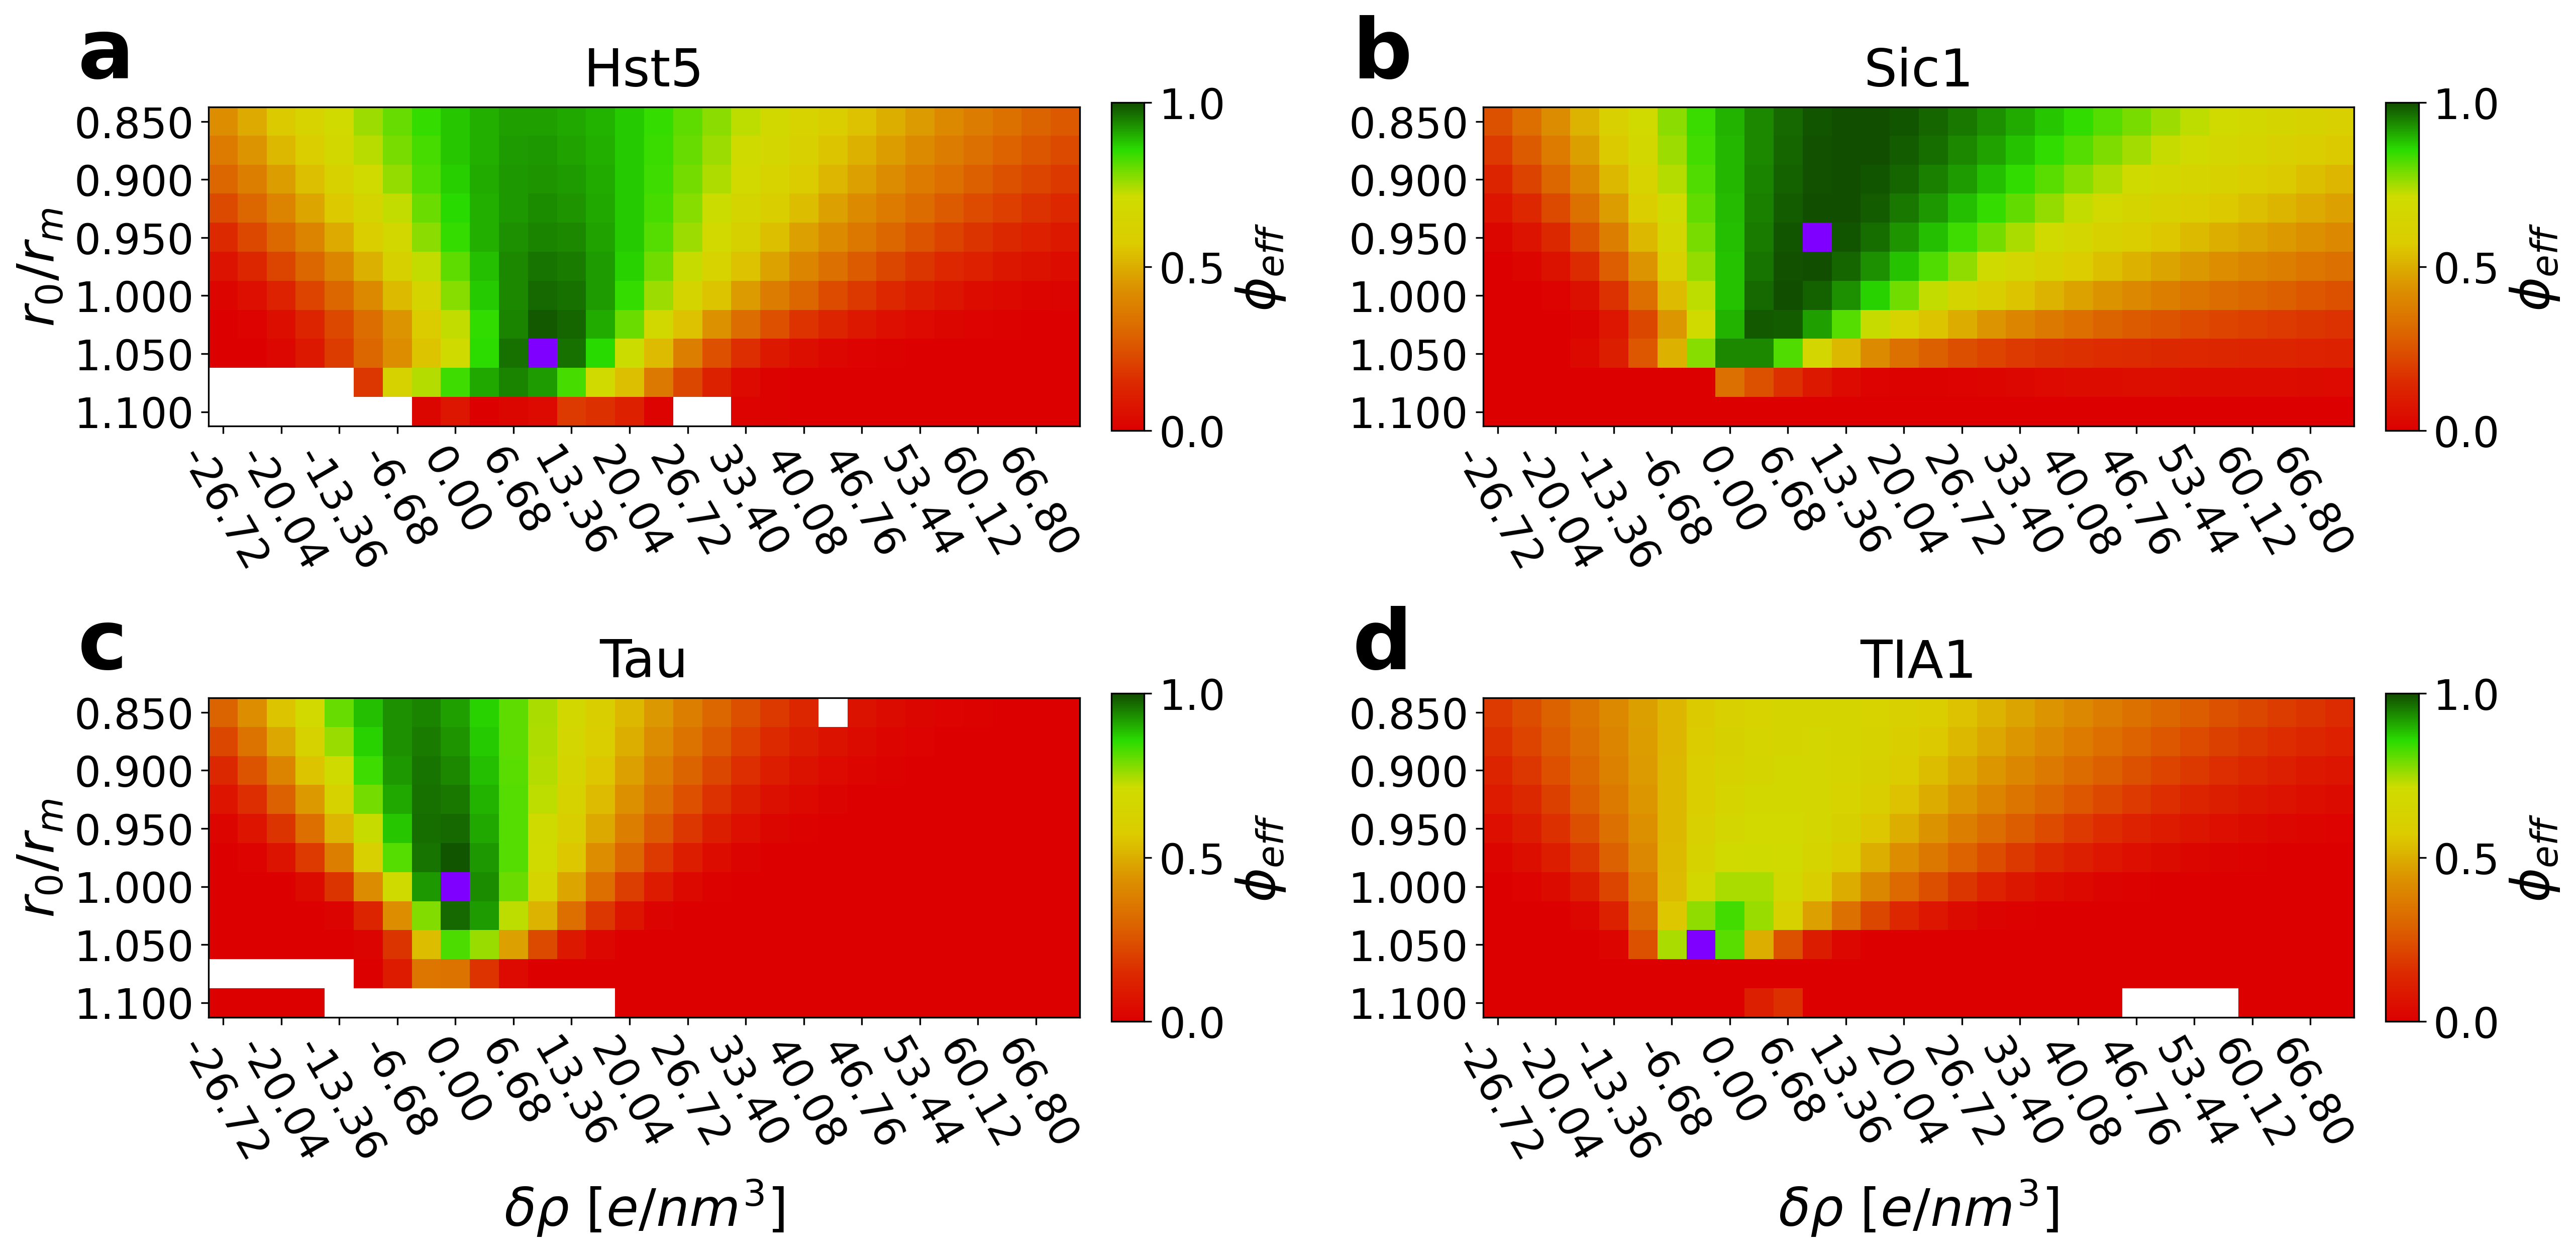

In [61]:
# Plotting relative entropies on the grid
mpl.rcParams['font.size'] = 20
fig, axs = plt.subplots(nrows=2,ncols=2, figsize=(20,10), facecolor='w', dpi=300, gridspec_kw={'hspace':0.08})
c=0
for i in range(2):
    axs[i,0].set_ylabel(r'$r_0/r_m$', fontsize=25)
    for j in range(2):
        p = tuple(grids.keys())[c]
        axs[i,j].set_title(p,pad=10, fontsize=25)
        im = axs[i,j].imshow(ent[p].reshape(len(dro),len(r0)).T, cmap=rtg_r)
        axs[i,j].set_yticks(np.arange(0,len(r0),2))
        axs[i,j].set_yticklabels(yt)
        axs[i,j].set_xticks(np.arange(0,len(dro),2))
        axs[i,j].set_xticklabels(xt, Rotation=300)
        axs[1,j].set_xlabel(r'$\delta\rho$ $[e/nm^3]$', fontsize=25)
        axs[i,j].text(-5,-1.5, string.ascii_lowercase[c], fontsize=40, weight='bold')
        plt.colorbar(im, ax=axs[i,j],shrink=0.6,pad=0.03,aspect=10).set_label(r'$\phi_{eff}$', fontsize=25)
        
        mask = np.full(np.shape(ent[p]),np.inf)
        mask[mins[p][0]] = 100
        axs[i,j].imshow(mask.reshape(len(dro),len(r0)).T, cmap=plt.cm.rainbow)
        
        c += 1
plt.savefig('figure2.pdf', dpi=300, facecolor='w', edgecolor='w', orientation='portrait')
plt.show()

In [10]:
# Calculate Rg for each conformer
rg = {}
for i,p in enumerate(proteins):
    rg[p] = rg_calc_mass(p+'_ENSEMBLE',sizes[i])

In [48]:
rg['TIA1'] = rg_calc_mass('TIA1_ENSEMBLE',sizes[-1])

In [50]:
# Calculate average Rg, weighted for each point of the grid
rg_avs = {}
for k,v in grids.items():
    rg_avs[k] = []
    wdir = k+'_WEIGHTS/'
    for i in v:
        gind = str(int(i[0]))
        if i[3] != np.inf:
            w = np.loadtxt(wdir+'w'+gind+'.dat')[...,1]
            rg_avs[k].append( np.average(rg[k].reshape(len(rg[k])), weights=w) )
        else:
            rg_avs[k].append(np.inf)

/storage1/francesco/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later


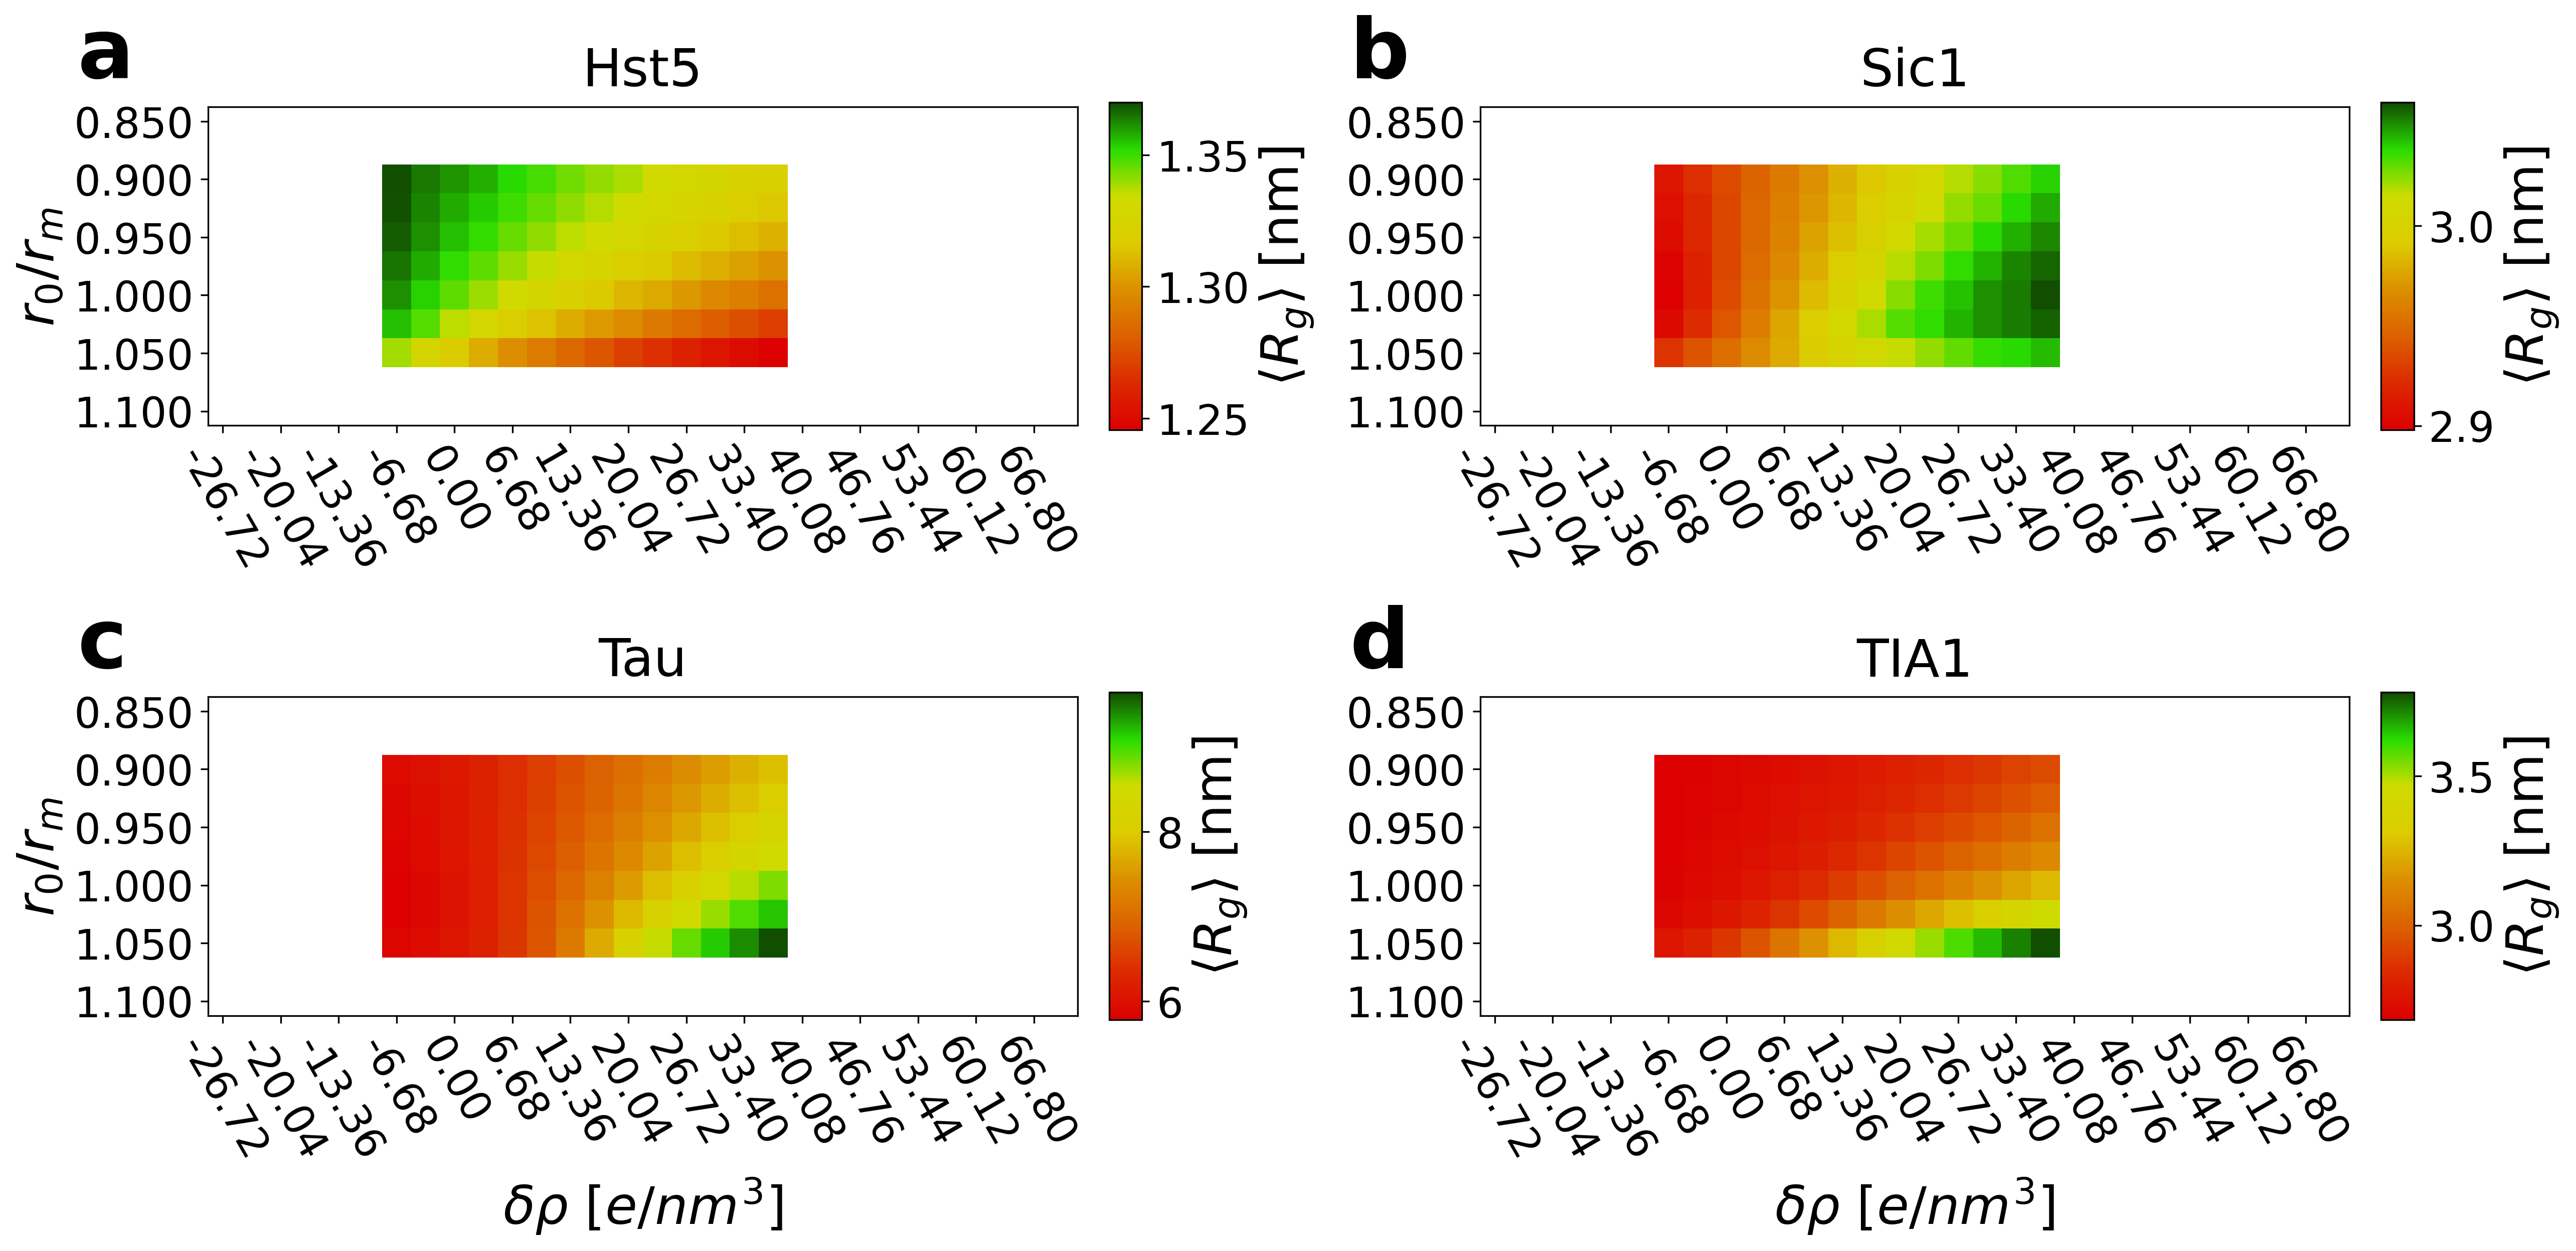

In [51]:
mpl.rcParams['font.size'] = 20
fig, axs = plt.subplots(nrows=2,ncols=2, figsize=(20,10), facecolor='w', dpi=300, gridspec_kw={'hspace':0.08})
c=0
for i in range(2):
    axs[i,0].set_ylabel(r'$r_0/r_m$', fontsize=25)
    for j in range(2):
        p = tuple(grids.keys())[c]
        axs[i,j].set_title(p,pad=10, fontsize=25)
        a = np.array(rg_avs[p]).reshape(len(dro),len(r0)).T
        a[:2,:] = np.inf
        a[9:,:] = np.inf
        a[:,0:6] =np.inf
        a[:,20:30] =np.inf
        im = axs[i,j].imshow(a, cmap=rtg_r)
        axs[i,j].set_yticks(np.arange(0,len(r0),2))
        axs[i,j].set_yticklabels(yt)
        axs[i,j].set_xticks(np.arange(0,len(dro),2))
        axs[i,j].set_xticklabels(xt, Rotation=300)
        axs[1,j].set_xlabel(r'$\delta\rho$ $[e/nm^3]$', fontsize=25)
        axs[i,j].text(-5,-1.5, string.ascii_lowercase[c], fontsize=40, weight='bold')
        plt.colorbar(im, ax=axs[i,j],shrink=0.6,pad=0.03,aspect=10).set_label(r'$\langle R_g \rangle$ [nm]', fontsize=25)
        
        c += 1
plt.savefig('figureS10.pdf', dpi=300, facecolor='w', edgecolor='w', orientation='portrait')
plt.show()

/lindorffgrp-isilon/francesco/PROJECTS/Robust-SAXS/Results_and_analysis/tools.py:54: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([x,kde,av])
/lindorffgrp-isilon/francesco/PROJECTS/Robust-SAXS/Results_and_analysis/tools.py:54: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([x,kde,av])
/lindorffgrp-isilon/francesco/PROJECTS/Robust-SAXS/Results_and_analysis/tools.py:54: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengt

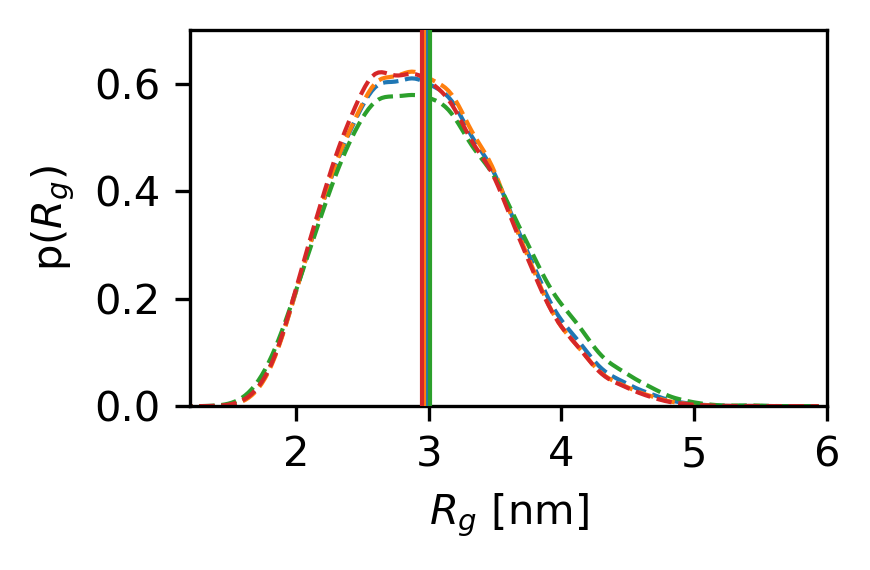

In [479]:
# Comparing reweighted Rg distributions and averages in spots of the Sic1 grid with optimal and suboptimal scores
mpl.rcParams['font.size'] = 10
fig, axs = plt.subplots(figsize=(3,2), facecolor='w', dpi=300)

dro_tmp = []
r0_tmp = []
chi2_tmp = []
phi_tmp = []
for c,i in zip(['tab:blue','tab:orange','tab:green','tab:red'],(125,121,176,96)):
    rg_tmp = rg_kde(rg['Sic1'], w = np.loadtxt('Sic1_WEIGHTS/w'+str(i)+'.dat')[...,1])
    axs.plot(rg_tmp[0],rg_tmp[1],c=c,lw=1, label=str(i),linestyle='dashed')
    
    axs.vlines(rg_tmp[2],0,0.9,color=c,zorder=300,lw=1)

    dro_tmp.append(grids['Sic1'][i,2]*3.34)
    r0_tmp.append(grids['Sic1'][i,2]*1.64)
    chi2_tmp.append(grids['Sic1'][i,3])
    phi_tmp.append(grids['Sic1'][i,4])
    
axs.set_ylabel(r'p($R_g$)')
axs.set_xlabel(r'$R_g$ [nm]')
axs.set_ylim(0,0.7)
axs.set_xlim(1.2,6)


#plt.legend(fontsize=5)
plt.tight_layout()
plt.savefig('rg.pdf', dpi=300, facecolor='w', edgecolor='w', orientation='portrait')
plt.show()

## FoXS grids

In [62]:
grids_foxs = {}
for p in proteins:
    grids_foxs[p] = np.loadtxt('FoXS/GRID_'+p)
    #calculate \gamma
    g = np.log(grids_foxs[p][...,4]/grids_foxs[p][...,5])
    g = g.reshape(len(g),1)
    grids_foxs[p] = np.append(grids_foxs[p], g, axis=1)

/storage1/francesco/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


In [66]:
dro_foxs = np.unique(grids_foxs['Hst5'][...,1])*13.5
r0_foxs = np.unique(grids_foxs['Hst5'][...,2])*1.62

yt_foxs = []
for i,x in enumerate(r0):
    if not (i+1)%2 == 0:
        yt_foxs.append('%.3f'%(x))
xt_foxs = []
for i,x in enumerate(dro):
    if not (i+1)%2 == 0:
        xt_foxs.append('%.2f'%(x))

In [67]:
min_foxs = {}
for k,v in grids_foxs.items():
    min_foxs[k] = minfind(v)

In [72]:
min_foxs

{'Hst5': (74, -1.6526821, 1.05),
 'Sic1': (140, 3.3053642, 1.05),
 'Tau': (2, -6.6107284, 0.9),
 'TIA1': (73, -1.6526821, 1.025)}

/storage1/francesco/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later


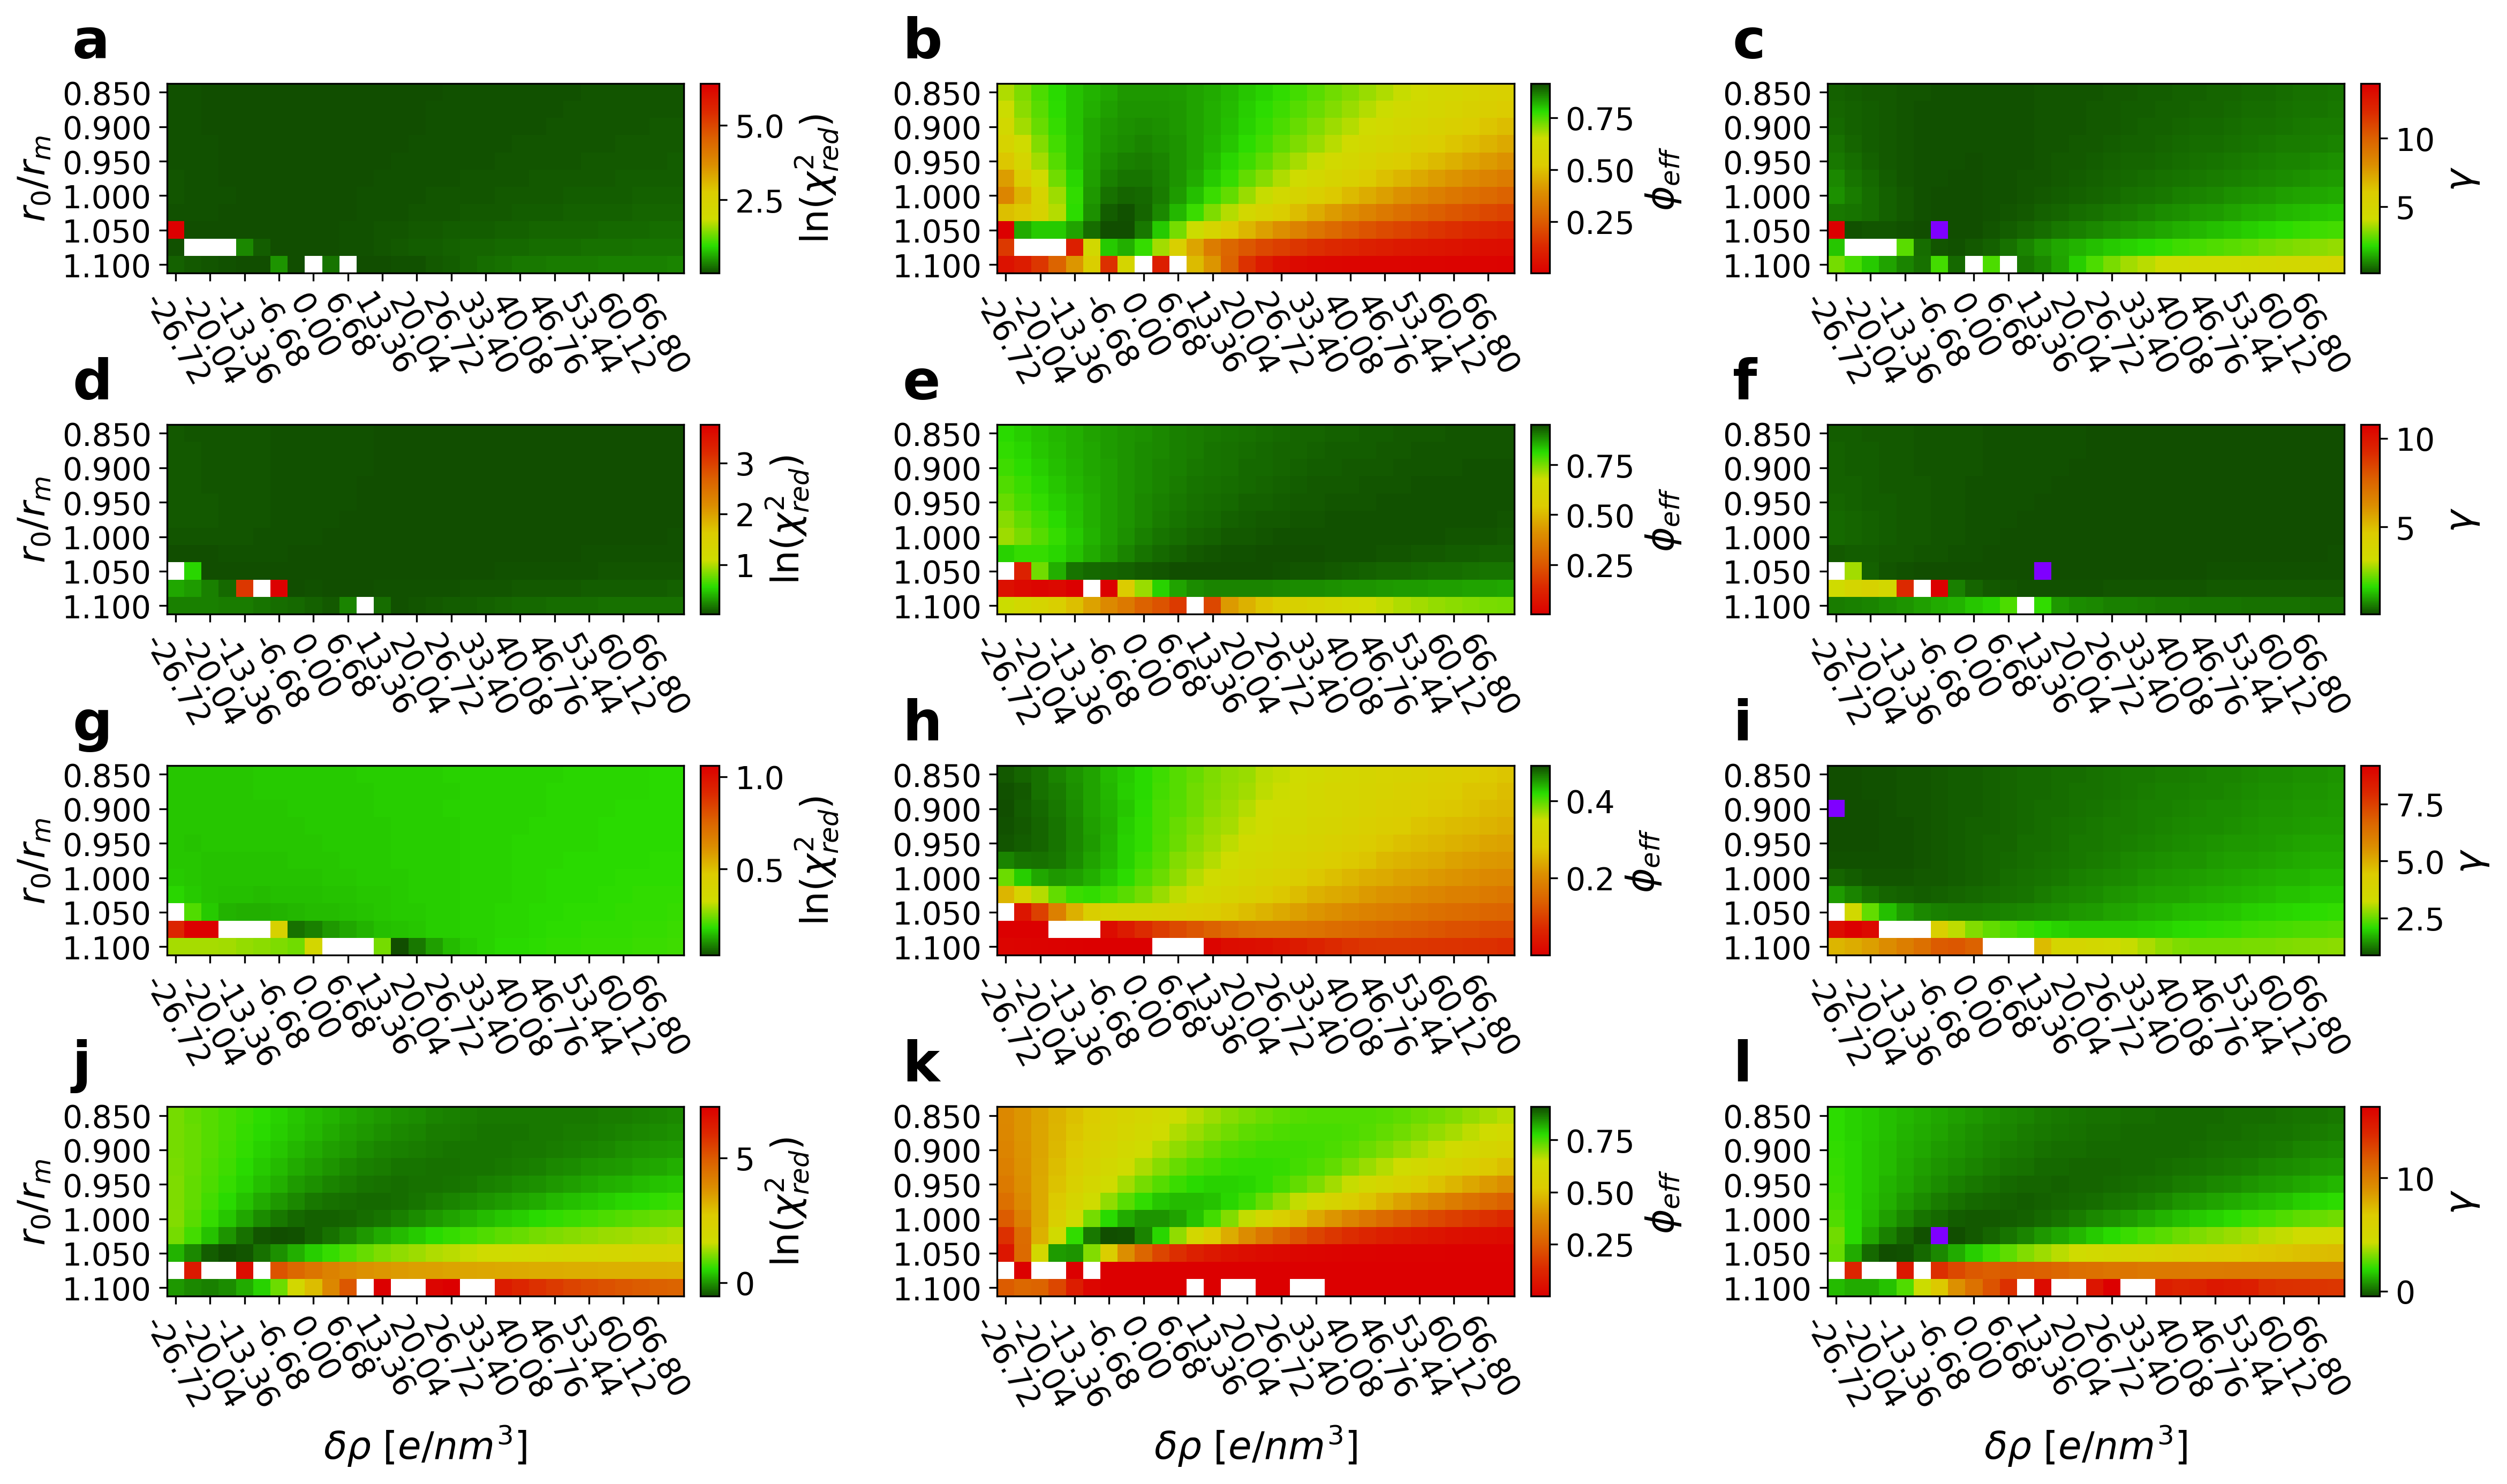

In [89]:
# Plotting grids
mpl.rcParams['font.size'] = 14
fig, axs = plt.subplots(nrows=4,ncols=3, figsize=(20,10), facecolor='w', dpi=300, gridspec_kw={'hspace':0.8,'wspace':0.001})
for i,p in enumerate(grids_foxs.keys()):
    im = axs[i,0].imshow(np.log(grids_foxs[p][...,4]).reshape(len(dro_foxs),len(r0_foxs)).T, cmap=rtg)
    plt.colorbar(im, ax=axs[i,0],shrink=1, pad=0.02, aspect=10).set_label(r'$\ln(\chi^2_{red})$', fontsize=17)
    
    im = axs[i,1].imshow(grids_foxs[p][...,5].reshape(len(dro_foxs),len(r0_foxs)).T, cmap=rtg_r)
    plt.colorbar(im, ax=axs[i,1],shrink=1, pad=0.02, aspect=10).set_label(r'$\phi_{eff}$', fontsize=17)
    
    im = axs[i,2].imshow(grids_foxs[p][...,6].reshape(len(dro_foxs),len(r0_foxs)).T, cmap=rtg)
    plt.colorbar(im, ax=axs[i,2],shrink=1, pad=0.02, aspect=10).set_label(r'$\gamma$', fontsize=17)
    mask = np.full(np.shape(grids_foxs[p][...,6]),np.inf)
    mask[min_foxs[p][0]] = 100
    axs[i,2].imshow(mask.reshape(len(dro),len(r0)).T, cmap=plt.cm.rainbow)
    
    
c=0
for i in range(4):
    axs[i,0].set_ylabel(r'$r_0/r_m$', fontsize=17)
    for j in range(3):
        axs[i,j].text(-6,-2, string.ascii_lowercase[c], fontsize=25, weight='bold')
        axs[i,j].set_yticks(np.arange(0,len(r0),2))
        axs[i,j].set_yticklabels(yt)
        axs[i,j].set_xticks(np.arange(0,len(dro),2))
        axs[i,j].set_xticklabels(xt, Rotation=300)
        axs[3,j].set_xlabel(r'$\delta\rho$ $[e/nm^3]$', fontsize=17)
        c+=1

plt.savefig('figureS8.pdf', dpi=300, facecolor='w', edgecolor='w', orientation='portrait')
plt.show()

In [70]:
s = 0
for k,v in grids_foxs.items():
    #min to 0
    shift = np.nanmin(v[...,6])
    tmp = v[...,6] - shift
    
    #rescale 0-1
    scale = np.nanmax(v[...,6])
    tmp /= scale
    
    s += tmp
s = s/len(proteins)
gmin = np.nanargmin(s)
print( gmin )
print( 'Global minimum dro: %.3f'%(grids_foxs['Hst5'][gmin][1]*13.5) )
print( 'Global minimum r0: %.3f'%(grids_foxs['Hst5'][gmin][2]) )

73
Global minimum dro: -6.680
Global minimum r0: 1.025


In [ ]:
# Download set of weights obtained from grid scanning+optimization
url = 'https://zenodo.org/record/5500084/files/FoXS_WEIGHTS.tar?download=1'
filename = wget.download(url)
my_tar = tarfile.open('FoXS_WEIGHTS.tar')
my_tar.extractall('./FoXS/')
my_tar.close()

/lindorffgrp-isilon/francesco/PROJECTS/Robust-SAXS/test/tools.py:54: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array([x,kde,av])
/lindorffgrp-isilon/francesco/PROJECTS/Robust-SAXS/test/tools.py:54: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array([x,kde,av])
/lindorffgrp-isilon/francesco/PROJECTS/Robust-SAXS/test/tools.py:54: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do th

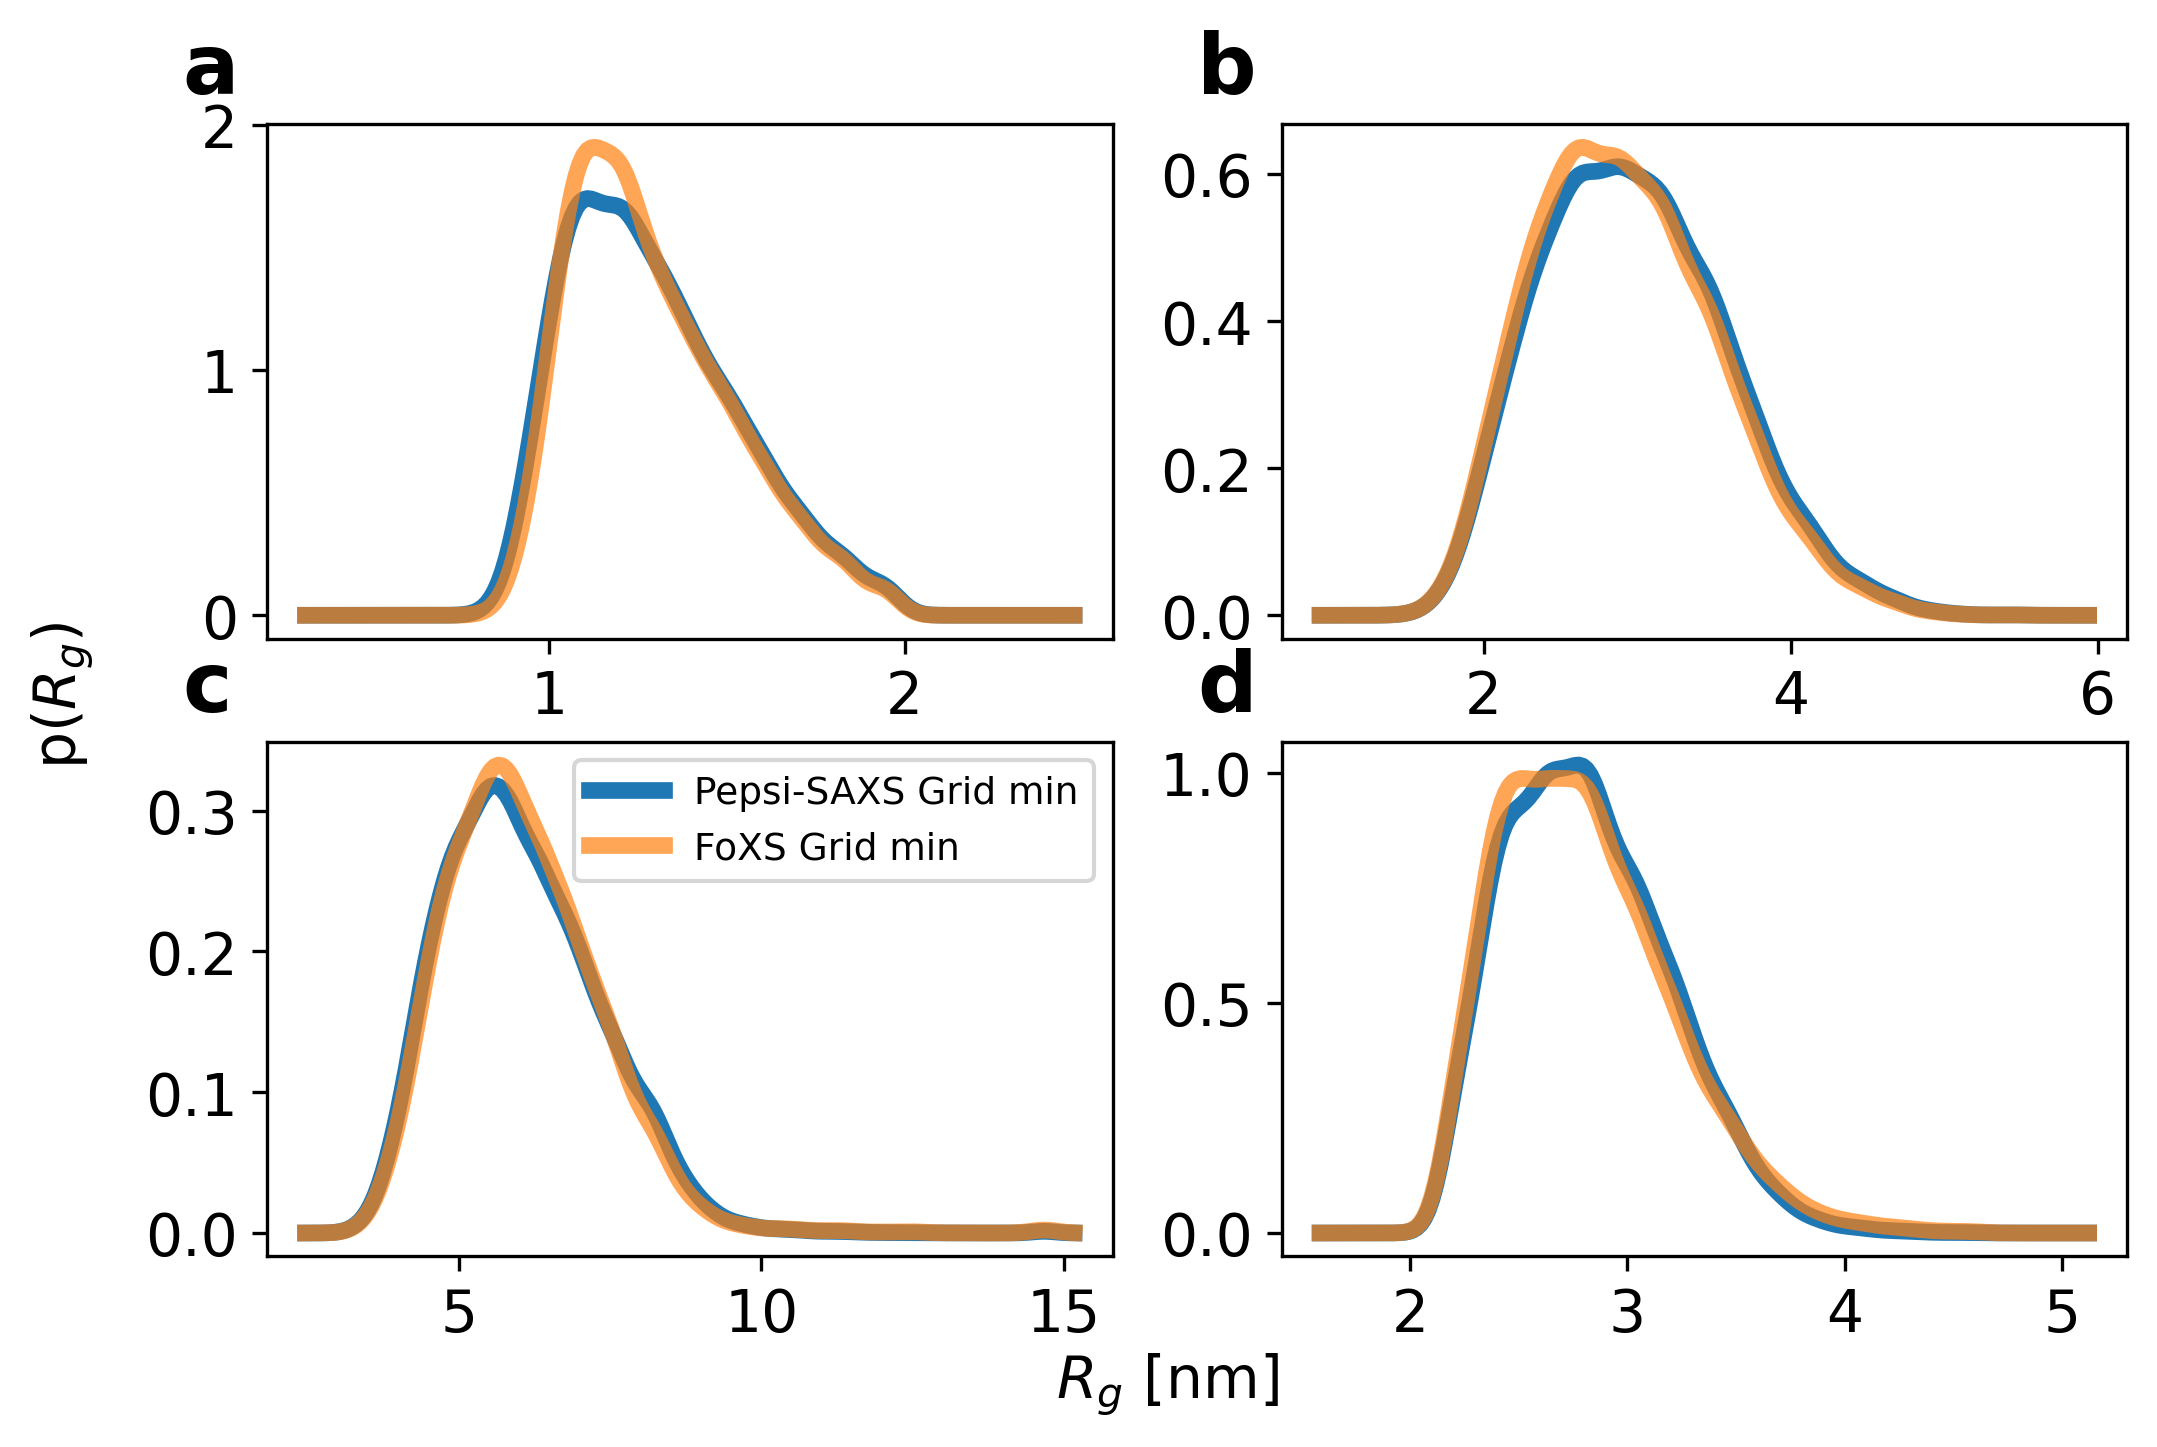

In [88]:
fig, axs = plt.subplots(ncols=2,nrows=2, dpi=300, figsize=(8,5))
for i,(ax,p) in enumerate(zip(axs.reshape(-1),proteins)):
    tmp_pepsi = rg_kde( rg[p].reshape(len(rg[p])), w = np.loadtxt(p+'_WEIGHTS/w'+str(mins[p][0])+'.dat')[...,1] )
    tmp_foxs = rg_kde( rg[p].reshape(len(rg[p])), w = np.loadtxt('FoXS/'+p+'_WEIGHTS/w'+str(min_foxs[p][0])+'.dat')[...,1] )
    ax.plot(tmp_pepsi[0],tmp_pepsi[1], lw=4, label='Pepsi-SAXS Grid min')
    ax.plot(tmp_foxs[0],tmp_foxs[1], lw=4, label='FoXS Grid min',alpha=0.7)
    ax.text(-0.1,1.06, string.ascii_lowercase[i], fontsize=20, weight='bold',transform=ax.transAxes)
axs[1,0].legend(fontsize=9)
fig.text(0.5, 0.04, r'$R_g$ [nm]', va='center', ha='center')
fig.text(0.04, 0.5, r'p($R_g$)', va='center', ha='center', rotation='vertical')

plt.savefig('figureS9.pdf', dpi=300, facecolor='w', edgecolor='w', orientation='portrait')

## aSyn - Prior comparison

In [53]:
ffs = ('FM', 'disp', 'a03ws')
sizes_asyn = {'FM': 20000, 'disp': 18281, 'a03ws': 14989}
grids_asyn = {}
for f in ffs:
    grids_asyn[f] = np.loadtxt('GRID_aSyn_'+f)
    #calculate \gamma
    g = np.log(grids_asyn[f][...,4]/grids_asyn[f][...,5])
    g = g.reshape(len(g),1)
    grids_asyn[f] = np.append(grids_asyn[f], g, axis=1)

/storage1/francesco/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


In [54]:
min_asyn = {}
for k,v in grids_asyn.items():
    min_asyn[k] = minfind(v)

/storage1/francesco/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later


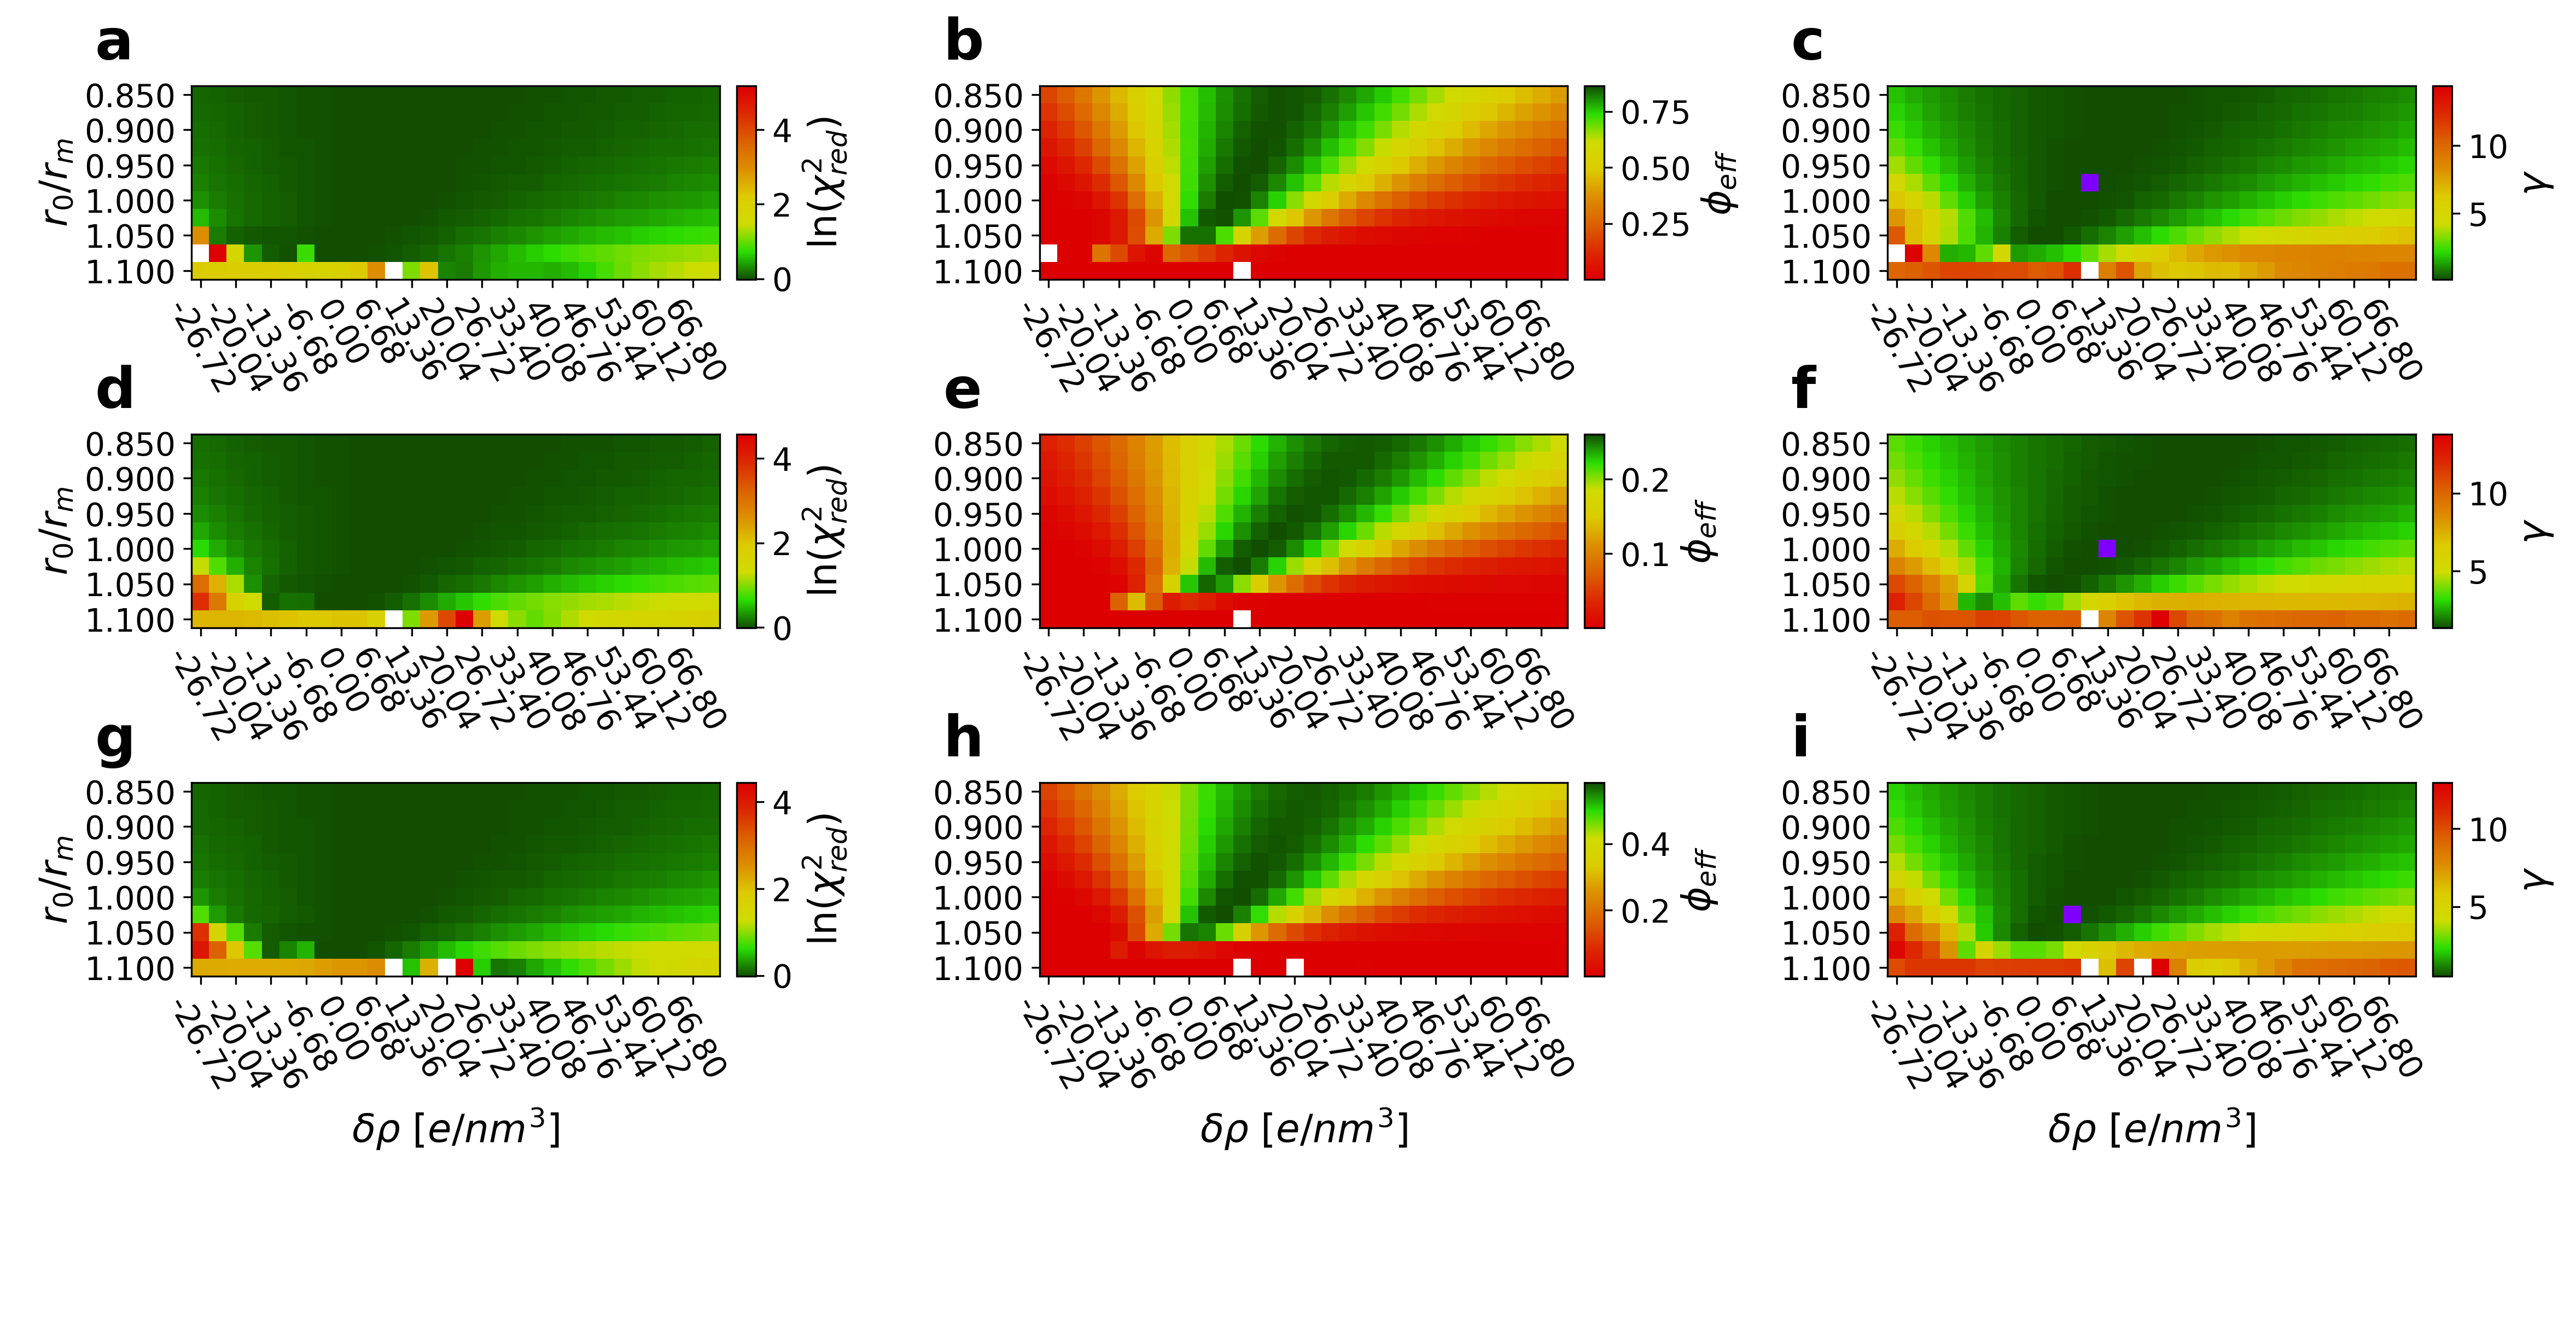

In [56]:
# Plotting grids_asyn
mpl.rcParams['font.size'] = 14
fig, axs = plt.subplots(nrows=4,ncols=3, figsize=(20,10), facecolor='w', dpi=300, gridspec_kw={'hspace':0.8,'wspace':0.001})
for i,p in enumerate(grids_asyn.keys()):
    im = axs[i,0].imshow(np.log(grids_asyn[p][...,4]).reshape(len(dro),len(r0)).T, cmap=rtg)
    plt.colorbar(im, ax=axs[i,0],shrink=1, pad=0.02, aspect=10).set_label(r'$\ln(\chi^2_{red})$', fontsize=17)
    
    im = axs[i,1].imshow(grids_asyn[p][...,5].reshape(len(dro),len(r0)).T, cmap=rtg_r)
    plt.colorbar(im, ax=axs[i,1],shrink=1, pad=0.02, aspect=10).set_label(r'$\phi_{eff}$', fontsize=17)
    
    im = axs[i,2].imshow(grids_asyn[p][...,6].reshape(len(dro),len(r0)).T, cmap=rtg)
    plt.colorbar(im, ax=axs[i,2],shrink=1, pad=0.02, aspect=10).set_label(r'$\gamma$', fontsize=17)
    mask = np.full(np.shape(grids_asyn[p][...,6]),np.inf)
    mask[min_asyn[p][0]] = 100
    axs[i,2].imshow(mask.reshape(len(dro),len(r0)).T, cmap=plt.cm.rainbow)

c=0
for i in range(3):
    axs[i,0].set_ylabel(r'$r_0/r_m$', fontsize=17)
    for j in range(3):
        axs[i,j].text(-6,-2, string.ascii_lowercase[c], fontsize=25, weight='bold')
        axs[i,j].set_yticks(np.arange(0,len(r0),2))
        axs[i,j].set_yticklabels(yt)
        axs[i,j].set_xticks(np.arange(0,len(dro),2))
        axs[i,j].set_xticklabels(xt, Rotation=300)
        axs[2,j].set_xlabel(r'$\delta\rho$ $[e/nm^3]$', fontsize=17)
        c+=1

axs[3,0].axis('off')
axs[3,1].axis('off')
axs[3,2].axis('off')
plt.savefig('figure5.pdf', dpi=300, facecolor='w', edgecolor='w', orientation='portrait')
plt.show()

In [58]:
# Calculate Rg for each conformer
rg_asyn = {}
for f in ffs:
    rg_asyn[f] = np.loadtxt('Rg_aSyn_'+f)

/lindorffgrp-isilon/francesco/PROJECTS/Robust-SAXS/test/tools.py:54: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array([x,kde,av])
/lindorffgrp-isilon/francesco/PROJECTS/Robust-SAXS/test/tools.py:54: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array([x,kde,av])
/lindorffgrp-isilon/francesco/PROJECTS/Robust-SAXS/test/tools.py:54: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do th

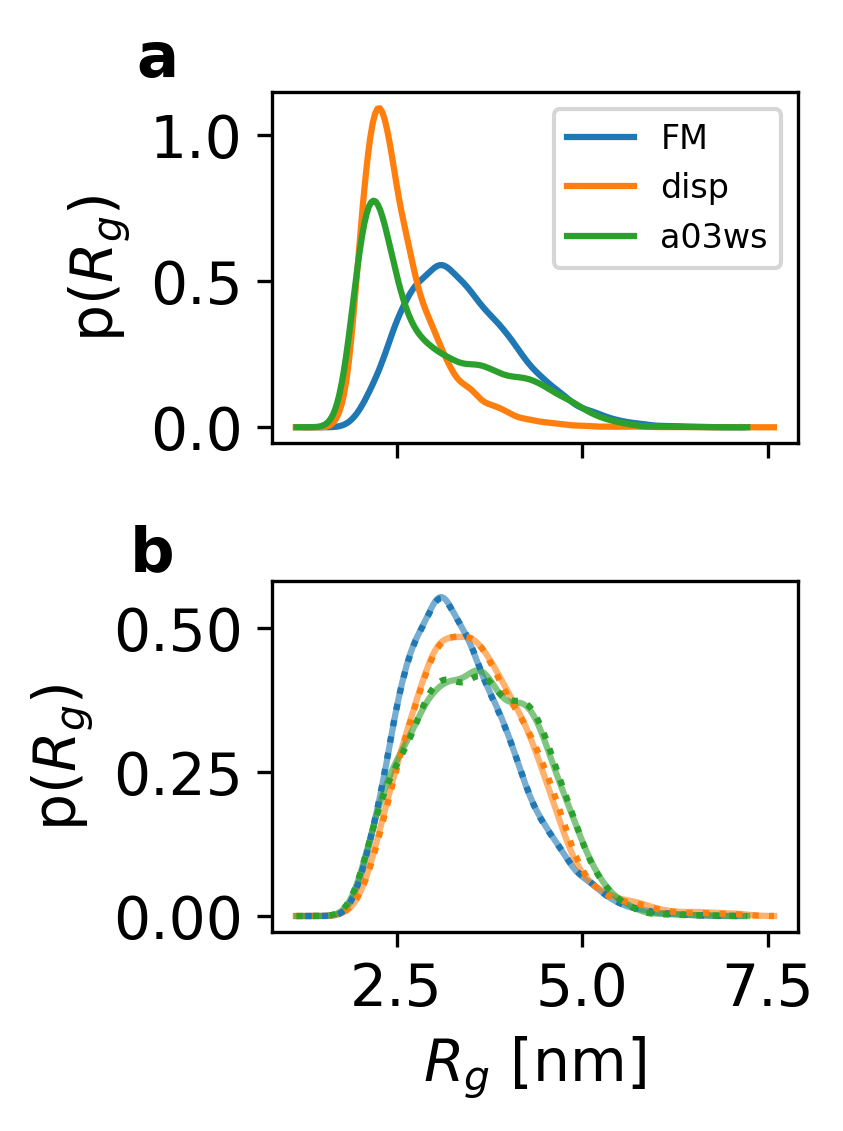

In [60]:
mpl.rcParams['font.size'] = 14
fig, (ax1,ax2) = plt.subplots(ncols=1,nrows=2,figsize=(3,4),dpi=300,sharex=True)

for k,v in rg_asyn.items():
    tmp = rg_kde( v.reshape(len(v)), w = np.full(len(v),1) )
    ax1.plot(tmp[0],tmp[1],label=k)
ax1.legend(fontsize=8)
ax1.text(-1,1.2, 'a', fontsize=15, weight='bold')
ax1.set_ylabel(r'p($R_g$)')

colors = ('C0','C1','C2')
c=0
for k,v in rg_asyn.items():
    tmp = rg_kde( v.reshape(len(v)), w = np.loadtxt('aSyn_'+k+'_WEIGHTS/w'+str(min_asyn[k][0])+'.dat')[...,1] )
    ax2.plot(tmp[0],tmp[1],label=k,c=colors[c],alpha=0.6)
    c+=1
    
c=0
for k,v in rg_asyn.items():
    tmp = rg_kde( v.reshape(len(v)), w = np.loadtxt('aSyn_'+k+'_WEIGHTS/w106.dat')[...,1] )
    ax2.plot(tmp[0],tmp[1],label=k,linestyle='dotted',c=colors[c])
    c+=1

ax2.text(-1.1,0.6, 'b', fontsize=15, weight='bold')
ax2.set_ylabel(r'p($R_g$)')
ax2.set_xlabel(r'$R_g$ [nm]')

plt.tight_layout()
plt.savefig('figure4.pdf', dpi=300, facecolor='w', edgecolor='w', orientation='portrait')
plt.show()

## Guinier analysis

In [16]:
# Guinier approximation on the experimental profiles variating the q-range
c = 0
guiniers = {}
cut = [10,0,0,0,0]
start = [125,8,10,15,10]
end = [350,100,100,200,100]
for k in exps.keys():
    guiniers[k] = guinier_scan(exps[k],cut[c],start[c],end[c])
    c = c+1

/storage1/francesco/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in sqrt
/storage1/francesco/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in sqrt


/lindorffgrp-isilon/francesco/PROJECTS/Robust-SAXS/Results_and_analysis/tools.py:54: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([x,kde,av])


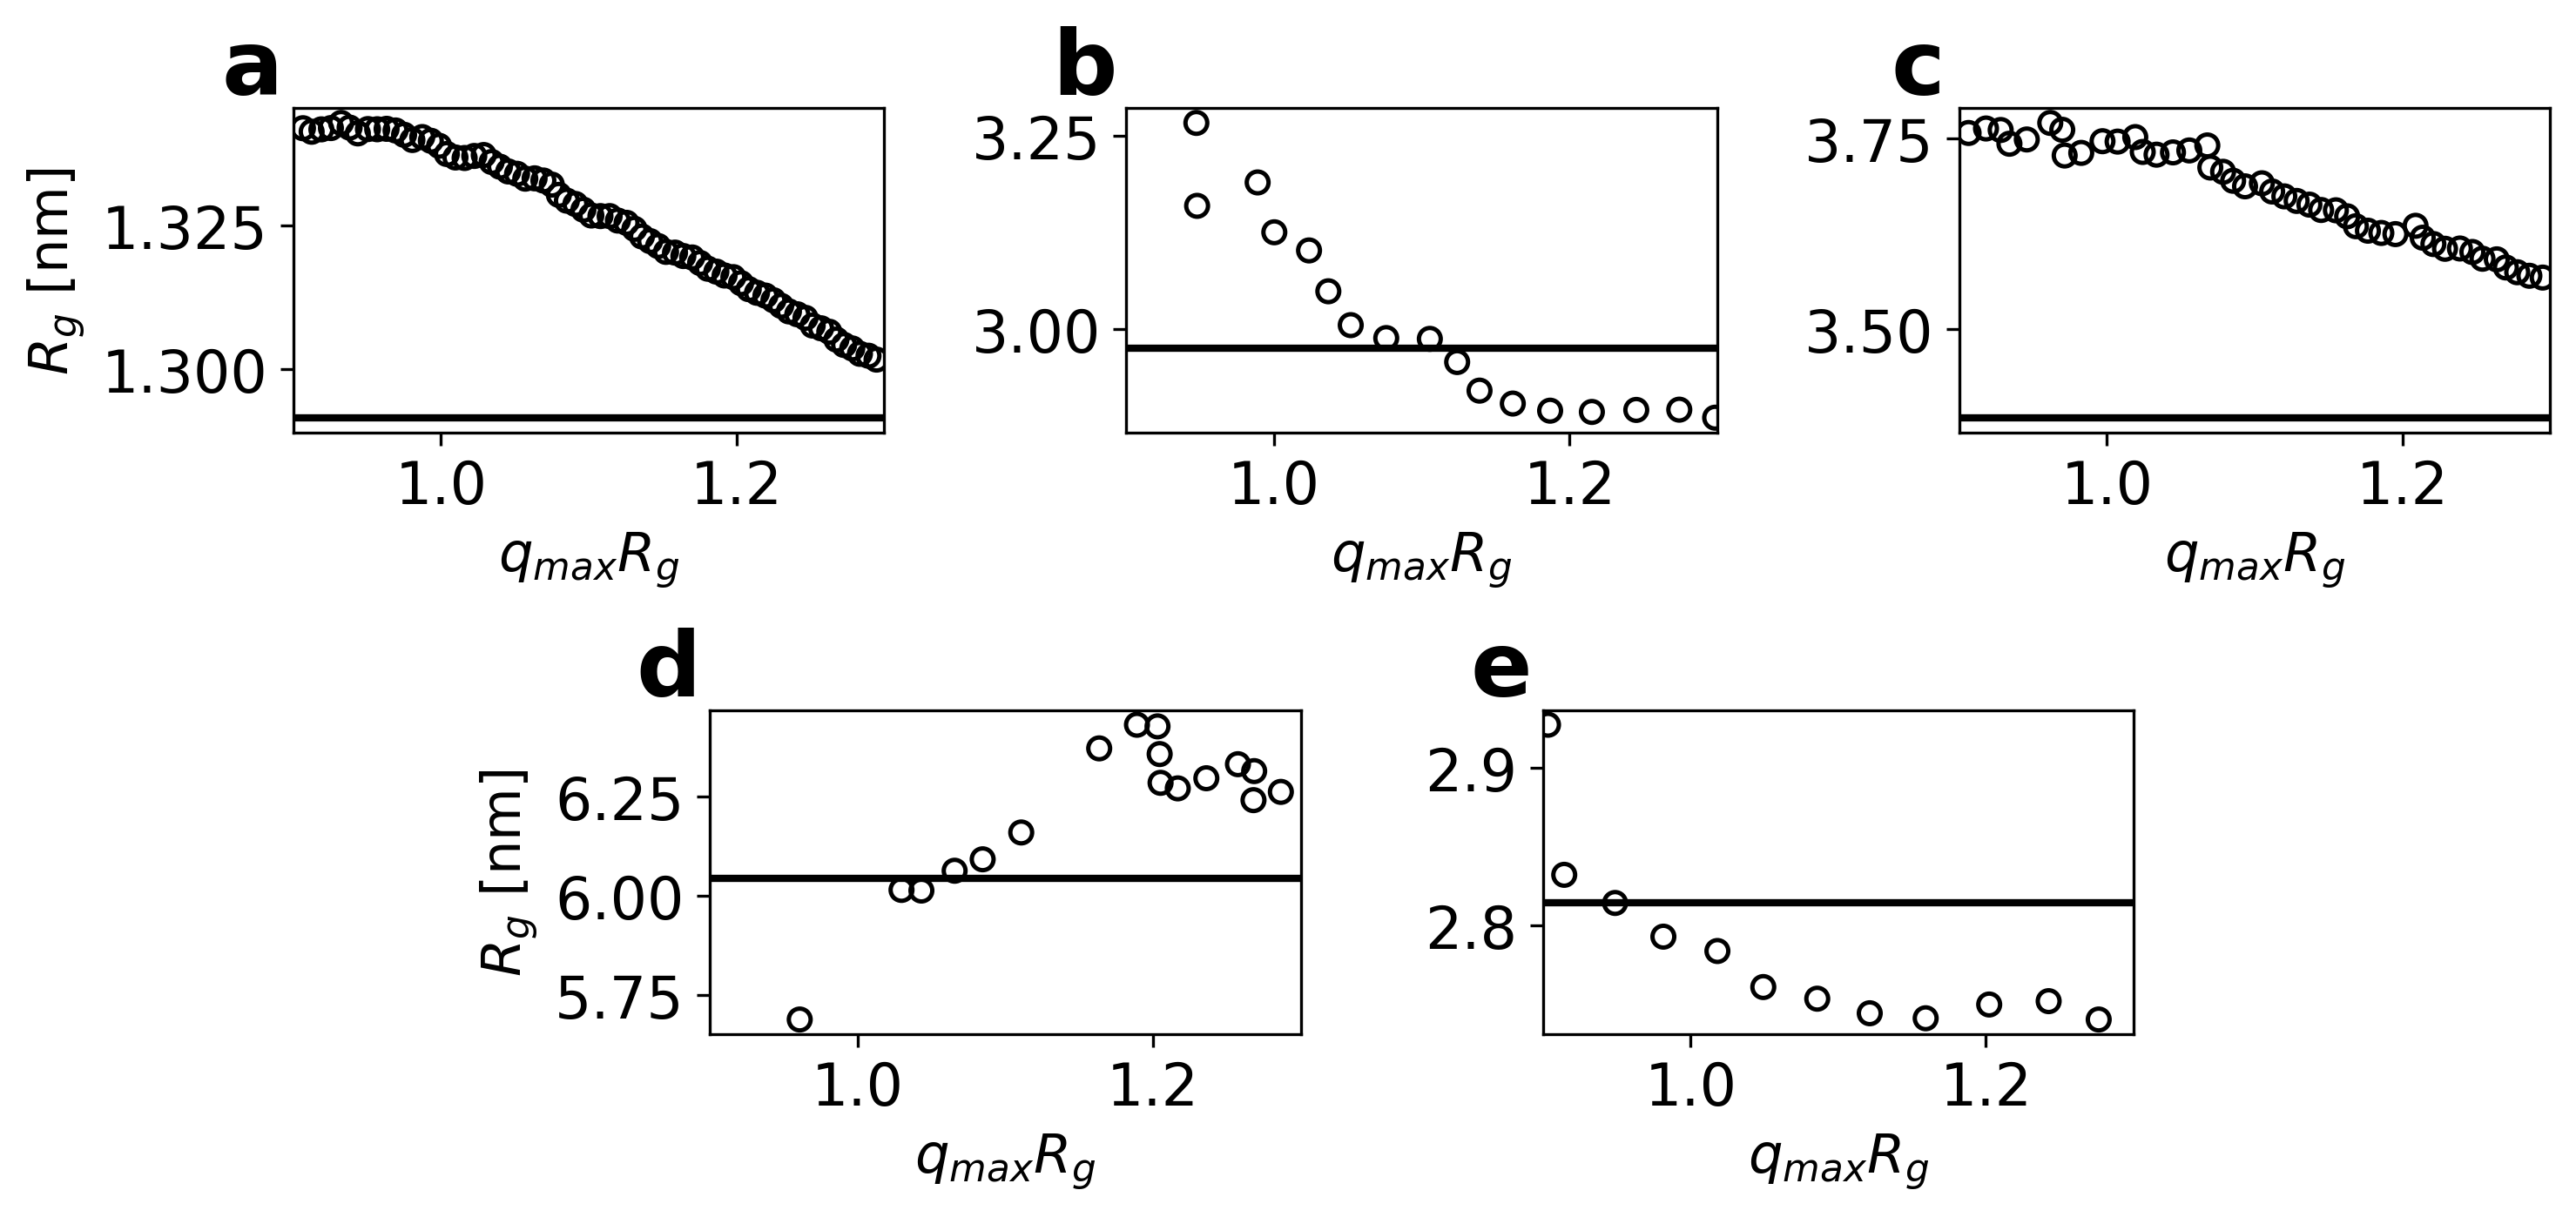

In [17]:
mpl.rcParams['font.size'] = 16
fig = plt.subplots(figsize=(10,5), facecolor='w', dpi=300,sharex=True)
ax1 = plt.subplot2grid(shape=(2,6), loc=(0,0), colspan=2)
ax2 = plt.subplot2grid((2,6), (0,2), colspan=2)
ax3 = plt.subplot2grid((2,6), (0,4), colspan=2)
ax4 = plt.subplot2grid((2,6), (1,1), colspan=2)
ax5 = plt.subplot2grid((2,6), (1,3), colspan=2)
axs = [ax1,ax2,ax3,ax4,ax5]

mins['aSyn'] = min_asyn['FM']

for i,p in enumerate(exps.keys()):
    im = axs[i].scatter(guiniers[p][0],guiniers[p][1],facecolors='none', edgecolors='k',linewidths=1.2)
    axs[i].text(-0.07,1.12, string.ascii_lowercase[i], fontsize=25, weight='bold',horizontalalignment='center', verticalalignment='center',transform=axs[i].transAxes)
    axs[i].set_xlim(0.9,1.3)
    axs[i].set_xlabel(r'$q_{max}R_{g}$', fontsize=15)
    if p == 'aSyn':
        rg_tmp = rg_kde(rg[p], w = np.loadtxt(p+'_FM_WEIGHTS/w'+str(mins[p][0])+'.dat')[...,1])
    else:
        rg_tmp = rg_kde(rg[p], w = np.loadtxt(p+'_WEIGHTS/w'+str(mins[p][0])+'.dat')[...,1])
    axs[i].hlines(rg_tmp[2], 0.9, 1.3, linewidth=2,color='k')
axs[0].set_ylabel(r'$R_{g}$ [nm]', fontsize=15)
axs[3].set_ylabel(r'$R_{g}$ [nm]', fontsize=15)
        
plt.tight_layout(w_pad=0.2,h_pad=0.4)
#plt.savefig('guinier.pdf', dpi=300, facecolor='w', edgecolor='w', orientation='portrait')